<a href="https://colab.research.google.com/github/spantoskey/DS-Unit-1-Sprint-1-Data-Wrangling-and-Storytelling/blob/master/Scott_Pantoskey_LS_DS_224_assignment.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Lambda School Data Science

*Unit 2, Sprint 2, Module 4*

---

# Classification Metrics

## Assignment
- [ ] If you haven't yet, [review requirements for your portfolio project](https://lambdaschool.github.io/ds/unit2), then submit your dataset.
- [ ] Plot a confusion matrix for your Tanzania Waterpumps model.
- [ ] Continue to participate in our Kaggle challenge. Every student should have made at least one submission that scores at least 70% accuracy (well above the majority class baseline).
- [ ] Submit your final predictions to our Kaggle competition. Optionally, go to **My Submissions**, and _"you may select up to 1 submission to be used to count towards your final leaderboard score."_
- [ ] Commit your notebook to your fork of the GitHub repo.
- [ ] Read [Maximizing Scarce Maintenance Resources with Data: Applying predictive modeling, precision at k, and clustering to optimize impact](http://archive.is/DelgE), by Lambda DS3 student Michael Brady. His blog post extends the Tanzania Waterpumps scenario, far beyond what's in the lecture notebook.


## Stretch Goals

### Reading

- [Attacking discrimination with smarter machine learning](https://research.google.com/bigpicture/attacking-discrimination-in-ml/), by Google Research, with  interactive visualizations. _"A threshold classifier essentially makes a yes/no decision, putting things in one category or another. We look at how these classifiers work, ways they can potentially be unfair, and how you might turn an unfair classifier into a fairer one. As an illustrative example, we focus on loan granting scenarios where a bank may grant or deny a loan based on a single, automatically computed number such as a credit score."_
- [Notebook about how to calculate expected value from a confusion matrix by treating it as a cost-benefit matrix](https://github.com/podopie/DAT18NYC/blob/master/classes/13-expected_value_cost_benefit_analysis.ipynb)
- [Visualizing Machine Learning Thresholds to Make Better Business Decisions](https://blog.insightdatascience.com/visualizing-machine-learning-thresholds-to-make-better-business-decisions-4ab07f823415)


### Doing
- [ ] Share visualizations in our Slack channel!
- [ ] RandomizedSearchCV / GridSearchCV, for model selection. (See module 3 assignment notebook)
- [ ] Stacking Ensemble. (See module 3 assignment notebook)
- [ ] More Categorical Encoding. (See module 2 assignment notebook)

In [1]:
%%capture
import sys

# If you're on Colab:
if 'google.colab' in sys.modules:
    DATA_PATH = 'https://raw.githubusercontent.com/LambdaSchool/DS-Unit-2-Kaggle-Challenge/master/data/'
    !pip install category_encoders==2.*

# If you're working locally:
else:
    DATA_PATH = '../data/'

In [3]:
# import necessary data packs
from category_encoders import OneHotEncoder, OrdinalEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, plot_confusion_matrix, classification_report
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
import numpy as np
import pandas as pd

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


# **I. Wrangle Data**

In [5]:
# WRANGLE FUNCTION

def wrangle(df):
  # Make a copy
  df = df.copy()

  # Drop repeat rows (observations)
  df.drop_duplicates(inplace=True)

  # Drop repeat columns (features)
  df.drop(columns=['quantity_group', 'extraction_type_group'], inplace=True)

  # Drop constant features
  df.drop(columns=['recorded_by'], inplace=True)

  # feature engineering
  df['pump_age'] = df['date_recorded'].dt.year - df['construction_year']
  df['date_recorded'] = df['date_recorded'].dt.year

  # drop datetime column
  df.drop(columns='date_recorded', inplace=True)

  # high-cardinality
  drop_cols = [col for col in df.select_dtypes('object').columns
               if df[col].nunique() > 100]
  df.drop(columns=drop_cols, inplace=True)

  # Drop features with lots of NaN values
  df.dropna(axis=1, thresh=len(df)*0.8, inplace=True)

  # Create new target with binary classification
  if 'status_group' in df:
    df['needs_repair'] = np.where(df['status_group']=='functional', 0, 1)
    df.drop(columns='status_group', inplace=True)

  return df


In [18]:
# Merge train_features.csv & train_labels.csv
train = pd.merge(pd.read_csv(DATA_PATH+'waterpumps/train_features.csv',
                             parse_dates=['date_recorded'],
                             na_values=[0, -2.000000e-08]), 
                 pd.read_csv(DATA_PATH+'waterpumps/train_labels.csv')).set_index('id')

# Read test_features.csv & sample_submission.csv
test = pd.read_csv(DATA_PATH+'waterpumps/test_features.csv',
                   parse_dates=['date_recorded'],
                   na_values=[0, -2.000000e-08],
                   index_col='id')
sample_submission = pd.read_csv(DATA_PATH+'waterpumps/sample_submission.csv')


# apply wrangle functions to test and train datasets

train = wrangle(train)
test = wrangle(test)


# **II. Split Data**

In [20]:
# split the target vector from the feature matrix
target = 'needs_repair'
y = train[target]
X = train.drop(columns=target)

# split the training set into validation and training sets
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size = 0.2, random_state=42)


# **III. Establish Baseline**

In [21]:
# identify the marjority class for y_train since it's a bianry classification
print('Baseline Accuracy:', y_train.value_counts(normalize=True).max())

Baseline Accuracy: 0.5441566645609602


# **IV. Build Model**

In [25]:
# instantiate and fit the model 
model = make_pipeline(
    OrdinalEncoder(),
    SimpleImputer(),
    RandomForestClassifier(n_jobs=-1,
                           random_state=42)
).fit(X_train, y_train)



# **V. Check Metrics**

In [26]:
# Accuracy scores
print('Training Accuracy:', model.score(X_train, y_train))
print('Validation Accuracy:', model.score(X_val, y_val))

Training Accuracy: 0.9957675300063171
Validation Accuracy: 0.8093994778067886


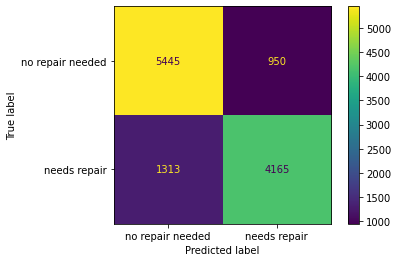

In [28]:
# Build a confusion matrix
plot_confusion_matrix(
    model, 
    X_val, 
    y_val,
    values_format='.0f',
    display_labels=['no repair needed', 'needs repair']
)

In [33]:
# print classification report
y_pred = model.predict(X_val)

print(classification_report(y_val,
                            y_pred,
                            target_names=['no repair needed', 'needs repair']))

                  precision    recall  f1-score   support

no repair needed       0.81      0.85      0.83      6395
    needs repair       0.81      0.76      0.79      5478

        accuracy                           0.81     11873
       macro avg       0.81      0.81      0.81     11873
    weighted avg       0.81      0.81      0.81     11873



# Make Submission

In [36]:
# predict results based on test set
y_pred = model.predict(test)

# build a series with two columns: ID and 'needs repair' status
data = {'id':test.index,
        'needs_repair':y_pred}

# convert to dataframe
submission = pd.DataFrame(data)

# submission.head()

,id,needs_repair
0,50785,1
1,51630,1
2,17168,0
3,45559,1
4,49871,0


In [37]:
# convert to csv
submission.to_csv('scott-pantoskey-kaggle-submission-v6.csv', index=False)